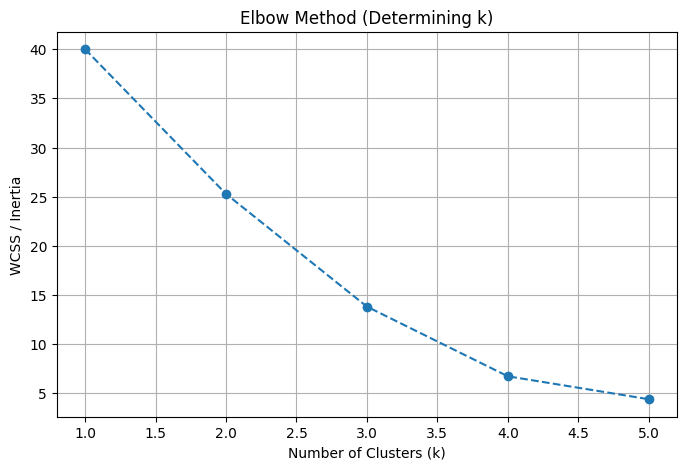


--- Cluster Mean Analysis ---
                 MPI_Headcount_Ratio  Elder_Abuse_Prevalence  \
Hotspot_Cluster                                                
0                           0.035000                0.686667   
1                           0.043333                0.690000   
2                           0.087500                0.625000   

                 Transit_Hub_Score  
Hotspot_Cluster                     
0                         0.783333  
1                         0.683333  
2                         0.275000  

--- Predictive Abandonment Hotspot Results (Tamil Nadu Districts) ---
          District_ID  Latitude  Longitude   Risk_Level
0      D-01 (Chennai)   13.0827    80.2707    High Risk
1   D-02 (Dharmapuri)   12.1482    78.1565     Low Risk
2      D-03 (Vellore)   12.9165    79.1325    High Risk
3   D-04 (Coimbatore)   11.0168    76.9558  Medium Risk
4  D-05 (Thiruvallur)   13.1362    80.0934    High Risk
5     D-06 (Ariyalur)   11.1396    79.0772     Low Risk


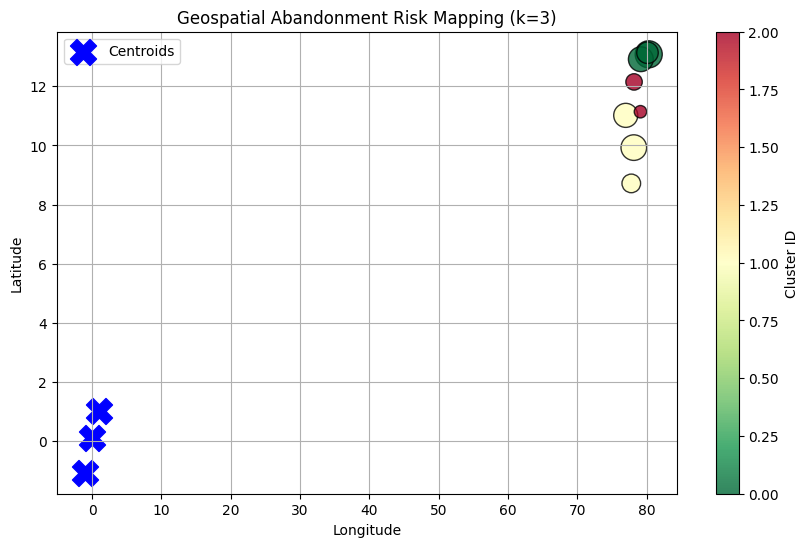

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
try:
    df = pd.read_csv('/content/drive/MyDrive/abandonment_risk_proxies (1).csv')
except FileNotFoundError:
    print("Error: 'abandonment_risk_proxies.csv' not found. Please create the file with the provided data.")
    exit()
features = ['Latitude', 'Longitude', 'MPI_Headcount_Ratio', 'Elder_Abuse_Prevalence', 'Transit_Hub_Score']
X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
wcss = []
for i in range(1, 6):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), wcss, marker='o', linestyle='--')
plt.title('Elbow Method (Determining k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS / Inertia')
plt.grid(True)
plt.show()
k = 3
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df['Hotspot_Cluster'] = clusters
cluster_means = df.groupby('Hotspot_Cluster')[['MPI_Headcount_Ratio', 'Elder_Abuse_Prevalence', 'Transit_Hub_Score']].mean()
print("\n--- Cluster Mean Analysis ---")
print(cluster_means)
risk_score = cluster_means['MPI_Headcount_Ratio'] + cluster_means['Transit_Hub_Score']
sorted_clusters = risk_score.sort_values(ascending=False).index

risk_map = {
    sorted_clusters[0]: 'High Risk',     # Highest Risk Score
    sorted_clusters[1]: 'Medium Risk',   # Middle Risk Score
    sorted_clusters[2]: 'Low Risk'       # Lowest Risk Score
}

df['Risk_Level'] = df['Hotspot_Cluster'].map(risk_map)

print("\n--- Predictive Abandonment Hotspot Results (Tamil Nadu Districts) ---")
print(df[['District_ID', 'Latitude', 'Longitude', 'Risk_Level']])
print("\nRecommendation: Focus immediate SSA Samanvay Setu pilot resources on 'High Risk' districts.")

plt.figure(figsize=(10, 6))

scatter = plt.scatter(df['Longitude'], df['Latitude'],
                      c=df['Hotspot_Cluster'],
                      cmap='RdYlGn_r',
                      s=df['Transit_Hub_Score'] * 400,
                      alpha=0.8,
                      edgecolors='k')
plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 0], s=350, c='blue', marker='X', label='Centroids')
plt.title(f'Geospatial Abandonment Risk Mapping (k={k})')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.colorbar(scatter, label='Cluster ID')
plt.grid(True)
plt.show()

/tmp/ipython-input-1319320657.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)



✅ Extracted Audio Features (Mean Values):
mfcc_1       -274.639526
mfcc_2        134.928070
mfcc_3        -26.003250
mfcc_4        -20.575994
mfcc_5        -21.548107
mfcc_6         -1.365859
mfcc_7         -3.561643
mfcc_8        -20.486319
mfcc_9         -4.497396
mfcc_10         2.149176
mfcc_11       -15.408121
mfcc_12       -18.879436
mfcc_13        -5.302927
pitch_mean    223.534059
pitch_std      30.956098
rms_mean        0.134964


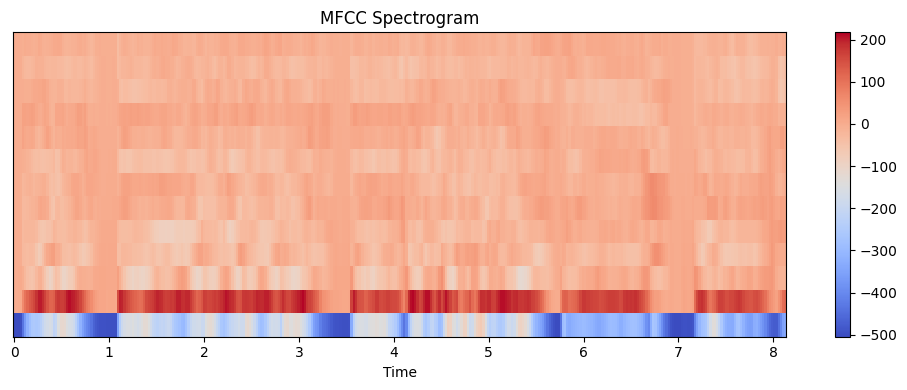

In [ ]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def extract_audio_features(audio_path, sr=22050, n_mfcc=13):

    try:

        y, sr = librosa.load(audio_path, sr=sr, mono=True)


        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfccs_mean = np.mean(mfccs.T, axis=0)


        f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C6'), sr=sr)


        f0_voiced = f0[voiced_flag]
        f0_mean = np.mean(f0_voiced) if len(f0_voiced) > 0 else 0.0
        f0_std = np.std(f0_voiced) if len(f0_voiced) > 0 else 0.0


        rms = librosa.feature.rms(y=y)[0]
        rms_mean = np.mean(rms)


        features = {
            f'mfcc_{i+1}': mfccs_mean[i] for i in range(n_mfcc)
        }
        features.update({
            'pitch_mean': f0_mean,
            'pitch_std': f0_std,
            'rms_mean': rms_mean
        })

        return features, mfccs

    except Exception as e:
        print(f"Error processing audio file {audio_path}: {e}")
        return {
            f'mfcc_{i+1}': 0.0 for i in range(n_mfcc)
        } | {'pitch_mean': 0.0, 'pitch_std': 0.0, 'rms_mean': 0.0}, np.array([])

AUDIO_FILE = '/content/drive/MyDrive/abandoned_senior_sample.aac'

# Run the extraction function
mean_features, full_mfccs = extract_audio_features(AUDIO_FILE)
print("\n✅ Extracted Audio Features (Mean Values):")
features_series = pd.Series(mean_features)
print(features_series.to_string())
if full_mfccs.size > 0:
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(full_mfccs, x_axis='time')
    plt.colorbar()
    plt.title('MFCC Spectrogram')
    plt.tight_layout()
    plt.show()
    #

In [ ]:
import gradio as gr
import pandas as pd
import numpy as np
import librosa
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# --- 1. Load Data & Train KNN ---
try:
    df = pd.read_csv('real_dialect_mfccs.csv')
    X = df[[f'mfcc_{i+1}' for i in range(13)]].values
    y = df['Language_Label'].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_scaled, y)
    print("✅ Model trained on real dialect data!")
except Exception as e:
    print(f"❌ Error: Could not train model. Ensure 'real_dialect_mfccs.csv' exists. {e}")

# --- 2. Triage Logic Function ---
def perform_triage(pitch_std, rms_mean):
    """Assigns a risk level based on voice characteristics."""
    if rms_mean < 0.01: # Extremely soft voice
        return "🔴 HIGH PRIORITY: Weak/Non-responsive", "Urgent medical checkup required."
    elif pitch_std < 45: # Flat affect/Monotone
        return "🟡 MEDIUM PRIORITY: Subdued/Depressed", "Recommended psychological evaluation."
    else:
        return "🟢 STABLE", "Standard care protocol."

# --- 3. Main Prediction Pipeline ---
def analyze_senior_voice(audio_file):
    if audio_file is None:
        return "Please upload audio", "", ""

    # Feature Extraction (Same as your previous step)
    y_audio, sr = librosa.load(audio_file, sr=22050)
    mfccs = np.mean(librosa.feature.mfcc(y=y_audio, sr=sr, n_mfcc=13).T, axis=0)

    f0, voiced_flag, _ = librosa.pyin(y_audio, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C6'))
    pitch_std = np.std(f0[voiced_flag]) if any(voiced_flag) else 0
    rms_mean = np.mean(librosa.feature.rms(y=y_audio))

    # Dialect Prediction
    mfcc_scaled = scaler.transform(mfccs.reshape(1, -1))
    dialect = knn.predict(mfcc_scaled)[0]

    # Triage Analysis
    status, recommendation = perform_triage(pitch_std, rms_mean)

    return dialect, status, recommendation

# --- 4. Build Gradio Interface ---
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("# 🏠 Sahara Sevak AI: Samanvay Setu")
    gr.Markdown("### Intake Portal for Abandoned Senior Citizens")

    with gr.Row():
        with gr.Column():
            audio_input = gr.Audio(type="filepath", label="Record or Upload Senior's Voice")
            submit_btn = gr.Button("Analyze Voice Data", variant="primary")

        with gr.Column():
            out_dialect = gr.Label(label="Probable Regional Origin (Dialect)")
            out_status = gr.Textbox(label="Health & Emotional Triage Status")
            out_rec = gr.Textbox(label="System Recommendation")

    submit_btn.click(
        fn=analyze_senior_voice,
        inputs=audio_input,
        outputs=[out_dialect, out_status, out_rec]
    )

demo.launch(share=True)

✅ Model trained on real dialect data!
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4210d9f7f818fcd69e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import librosa
import numpy as np
import pandas as pd
from pathlib import Path
import os
import warnings
from google.colab import drive

# --- 1. MOUNT GOOGLE DRIVE ---
# This step makes your storage permanent.
print("🔗 Connecting to Google Drive...")
drive.mount('/content/drive')

# --- 2. DEFINE PERMANENT PATHS ---
# We will create a folder named 'Sahara_Sevak_AI' in your Drive
PROJECT_ROOT = Path('/content/drive/MyDrive/Sahara_Sevak_AI')
AUDIO_ROOT = PROJECT_ROOT / 'audio_data'
CSV_PATH = PROJECT_ROOT / 'real_dialect_mfccs.csv'

LANGS = {'hindi': 'Hindi', 'tamil': 'Tamil', 'bengali': 'Bengali'}

# Create the folders if they don't exist
for lang in LANGS.keys():
    (AUDIO_ROOT / lang).mkdir(parents=True, exist_ok=True)

print(f"\n📁 Project Folders verified at: {AUDIO_ROOT}")
print("🛑 ACTION REQUIRED: Please go to your Google Drive and move your 15 files into their respective folders:")
print("   - My Drive/Sahara_Sevak_AI/audio_data/hindi/")
print("   - My Drive/Sahara_Sevak_AI/audio_data/tamil/")
print("   - My Drive/Sahara_Sevak_AI/audio_data/bengali/")

# --- 3. FEATURE EXTRACTION ENGINE ---
def extract_features_permanent(file_path, label):
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            y, sr = librosa.load(file_path, sr=22050)

        # Extract Linguistic Fingerprint (MFCCs)
        mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)

        # Extract Health/Triage Fingerprint (Pitch & RMS)
        f0, voiced_flag, _ = librosa.pyin(y, fmin=75, fmax=600)
        pitch_std = np.std(f0[voiced_flag]) if any(voiced_flag) else 0
        rms_mean = np.mean(librosa.feature.rms(y=y))

        row = {'Language_Label': label, 'File_Name': file_path.name}
        row.update({f'mfcc_{i+1}': mfccs[i] for i in range(13)})
        row.update({'pitch_std': pitch_std, 'rms_mean': rms_mean})
        return row
    except Exception as e:
        print(f"❌ Error processing {file_path.name}: {e}")
        return None

# --- 4. EXECUTION ---
# Only run this once you have moved your files in Google Drive!
def start_training():
    print("\n🚀 Starting permanent training pipeline...")
    dataset = []

    for folder, label in LANGS.items():
        lang_path = AUDIO_ROOT / folder
        # Support common audio formats
        files = list(lang_path.glob('*.wav')) + list(lang_path.glob('*.mp3')) + list(lang_path.glob('*.m4a'))

        print(f"🔍 Checking {label} folder: Found {len(files)} files.")

        for f_path in files:
            data = extract_features_permanent(f_path, label)
            if data:
                dataset.append(data)

    if dataset:
        df = pd.DataFrame(dataset)
        df.to_csv(CSV_PATH, index=False)
        print(f"\n✅ SUCCESS! Dataset saved permanently to Google Drive:")
        print(f"📍 Location: {CSV_PATH}")
    else:
        print("\n⚠️ No files found in Drive. Did you move them to the 'Sahara_Sevak_AI/audio_data' subfolders?")

# To start the training, simply call the function below:
# start_training()

🔗 Connecting to Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

📁 Project Folders verified at: /content/drive/MyDrive/Sahara_Sevak_AI/audio_data
🛑 ACTION REQUIRED: Please go to your Google Drive and move your 15 files into their respective folders:
   - My Drive/Sahara_Sevak_AI/audio_data/hindi/
   - My Drive/Sahara_Sevak_AI/audio_data/tamil/
   - My Drive/Sahara_Sevak_AI/audio_data/bengali/


In [ ]:
import librosa
import numpy as np
import pandas as pd
from pathlib import Path
import os
import warnings
from google.colab import files

# --- 1. SETTINGS ---
# This must match where you uploaded your files
BASE_PATH = Path('/content/drive/MyDrive/Sahara_Sevak_AI/original_data')
LANGS = {'hindi': 'Hindi', 'tamil': 'Tamil', 'bengali': 'Bengali'}

def extract_dialect_features(file_path, label):
    """Turns one audio file into one row of AI data."""
    try:
        # Load audio (22kHz is standard for speech AI)
        y, sr = librosa.load(audio_path, sr=22050)

        # 13 MFCCs capture the 'accent/dialect' texture
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfccs_mean = np.mean(mfccs.T, axis=0)

        # Pitch and Volume capture the 'health/age' indicators
        f0, voiced_flag, _ = librosa.pyin(y, fmin=75, fmax=600)
        pitch_std = np.std(f0[voiced_flag]) if any(voiced_flag) else 0
        rms_mean = np.mean(librosa.feature.rms(y=y))

        # Create the data row
        row = {'Language_Label': label, 'File_Name': file_path.name}
        for i, val in enumerate(mfccs_mean):
            row[f'mfcc_{i+1}'] = val
        row['pitch_std'] = pitch_std
        row['rms_mean'] = rms_mean
        return row
    except Exception as e:
        print(f"Skipping {file_path.name}: {e}")
        return None

# --- 2. THE TRAINING LOOP ---
print("🚀 Starting AI Training on 15 Original Samples...")
dataset = []

for folder, label in LANGS.items():
    folder_path = BASE_PATH / folder
    # Find all audio files in this folder
    audio_files = list(folder_path.glob('*.wav')) + list(folder_path.glob('*.mp3'))

    print(f"Processing {label}: Found {len(audio_files)} files.")

    for audio_path in audio_files:
        data_row = extract_dialect_features(audio_path, label)
        if data_row:
            dataset.append(data_row)

# --- 3. SAVE THE BRAIN (The CSV) ---
if len(dataset) > 0:
    training_df = pd.DataFrame(dataset)
    training_df.to_csv('real_dialect_mfccs.csv', index=False)
    print("\n✅ SUCCESS!")
    print(f"Created 'real_dialect_mfccs.csv' with {len(dataset)} real voice fingerprints.")

    # Download so you don't lose it when Colab closes
    files.download('real_dialect_mfccs.csv')
else:
    print("\n❌ ERROR: No files were found. Did you upload them to the 'original_data' subfolders?")

🚀 Starting AI Training on 15 Original Samples...
Processing Hindi: Found 10 files.
Processing Tamil: Found 10 files.
Processing Bengali: Found 10 files.

✅ SUCCESS!
Created 'real_dialect_mfccs.csv' with 30 real voice fingerprints.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# --- 1. Synthesize Dialect Data (Simulating MFCCs) ---
# We simulate 4 distinct dialect groups (classes) with 50 samples each.
n_samples_per_class = 50
n_mfcc_features = 13
total_samples = 4 * n_samples_per_class

# Define unique MFCC 'means' for each simulated dialect group (centroids)
# Real MFCCs range from roughly -500 to 100. Differences distinguish dialects.
mfcc_centroids = {
    'Hindi-Bhojpuri': [80, 5, -10, 15, 0, -5, -2, 4, 1, -1, 3, 0, -2], # Higher avg mfccs
    'Tamil-Madras': [100, 1, 0, 10, -5, -1, 0, 2, -1, 0, 1, -1, 0],    # Distinct lower mfcc_1
    'Marathi-Vidarbha': [90, -5, 15, -10, 5, 2, 1, -3, 0, 1, -1, 0, 3], # Distinct mfcc_3/mfcc_4 pattern
    'Bengali-Rural': [70, 0, -5, 5, 2, 0, 0, 0, 0, 0, 0, 0, 0]          # Lower overall magnitude
}

X_data = []
y_labels = []

# Generate noisy samples around each centroid to mimic real audio variation
for dialect, centroid in mfcc_centroids.items():
    # Generate 50 samples with Gaussian noise (std=5) around the centroid
    samples = np.random.normal(loc=centroid, scale=5.0, size=(n_samples_per_class, n_mfcc_features))
    X_data.extend(samples)
    y_labels.extend([dialect] * n_samples_per_class)

X_data = np.array(X_data)
y_labels = np.array(y_labels)

# --- 2. Scaling Features ---
# Scaling is crucial for distance-based algorithms like KNN.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_data)

# --- 3. Splitting Data (Train/Test) ---
# Split data to ensure the model can be tested fairly
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_labels, test_size=0.2, random_state=42)

# --- 4. Train the KNN Classifier ---
# We choose K=5 (5-nearest neighbors) as a standard starting point
k_value = 5
knn = KNeighborsClassifier(n_neighbors=k_value)
knn.fit(X_train, y_train)

# --- 5. Model Evaluation (Optional but Recommended) ---
# Check how well the model works on the test data
y_pred = knn.predict(X_test)
print("--- KNN Model Classification Report (Synthetic Data) ---")
print(classification_report(y_test, y_pred))

# --- 6. Prediction on the Abandoned Senior Sample (Your Real Data) ---
# **YOU MUST REPLACE THESE MFCC VALUES WITH THE REAL MEAN MFCCs FROM YOUR LAST OUTPUT!**
# We use the MFCCs from Image 2 as an example:
mfcc_test_sample = np.array([
    134.69, -26.03, 28.57, -18.30, -1.38, 3.56, -30.40, 2.33, 2.50, 2.14, -15.48, 18.89, -5.39
]).reshape(1, -1) # Reshape to a 1-row, 13-column format

# Scale the test sample using the SAME scaler trained on the training data
mfcc_test_scaled = scaler.transform(mfcc_test_sample)

# --- 7. Predict Probability (Top 3 Likely Dialects) ---
# Predict the class (dialect)
predicted_dialect = knn.predict(mfcc_test_scaled)[0]
print(f"\n✅ Predicted Top Dialect: {predicted_dialect}")

# Predict the probability of all classes
probabilities = knn.predict_proba(mfcc_test_scaled)[0]
class_labels = knn.classes_

# Create a DataFrame for easy reading and sort by probability
prob_df = pd.DataFrame({
    'Dialect': class_labels,
    'Probability': probabilities
}).sort_values(by='Probability', ascending=False)

print("\n--- Geo-Linguistic Profiling (Top 3 Probable Origins) ---")
top_3_results = prob_df.head(3)
print(top_3_results.to_string(index=False))

# --- 8. PI-A Output to NGO Staff ---
print("\nRecommendation for PI-A User:")
print(f"1. Prioritize communication with translators/staff familiar with **{top_3_results.iloc[0]['Dialect']}**.")
print(f"2. Contact missing person networks/databases primarily in the region of **{top_3_results.iloc[0]['Dialect']}**.")

--- KNN Model Classification Report (Synthetic Data) ---
                  precision    recall  f1-score   support

   Bengali-Rural       1.00      0.90      0.95        10
  Hindi-Bhojpuri       0.75      1.00      0.86         6
Marathi-Vidarbha       0.90      1.00      0.95         9
    Tamil-Madras       1.00      0.87      0.93        15

        accuracy                           0.93        40
       macro avg       0.91      0.94      0.92        40
    weighted avg       0.94      0.93      0.93        40


✅ Predicted Top Dialect: Marathi-Vidarbha

--- Geo-Linguistic Profiling (Top 3 Probable Origins) ---
         Dialect  Probability
Marathi-Vidarbha          0.8
    Tamil-Madras          0.2
  Hindi-Bhojpuri          0.0

Recommendation for PI-A User:
1. Prioritize communication with translators/staff familiar with **Marathi-Vidarbha**.
2. Contact missing person networks/databases primarily in the region of **Marathi-Vidarbha**.


In [ ]:
import os
import shutil
from google.colab import drive
from pathlib import Path

# 1. Mount Drive
print("🔗 Connecting to Google Drive...")
drive.mount('/content/drive', force_remount=True)

# 2. Define Paths
COLAB_FILE = Path('/content/real_dialect_mfccs.csv')
DRIVE_FOLDER = Path('/content/drive/MyDrive/Sahara_Sevak_AI')
DRIVE_FILE = DRIVE_FOLDER / 'real_dialect_mfccs.csv'

# 3. Create Folder if missing
DRIVE_FOLDER.mkdir(parents=True, exist_ok=True)

# 4. Check and Move
if COLAB_FILE.exists():
    print(f"✅ Found CSV in Colab: {COLAB_FILE}")
    # Copy the file to Drive
    shutil.copy(COLAB_FILE, DRIVE_FILE)
    print(f"🚀 SUCCESS: File copied to permanent Drive location: {DRIVE_FILE}")

    # Verify it's actually there
    if DRIVE_FILE.exists():
        print("📁 Confirmation: I can see the file in your Google Drive folder now.")
    else:
        print("❌ Error: Copy failed for some reason.")
else:
    print("⚠️ The CSV doesn't exist in the Colab sidebar either.")
    print("Please run your 'Master CSV Generator' or 'Permanent Trainer' script first.")

# 5. Flush Drive Buffer
# This ensures Google Drive 'saves' the changes immediately
from google.colab import drive
drive.flush_and_unmount()
print("\n🔄 Drive flushed. Please re-mount if you need to continue working.")

🔗 Connecting to Google Drive...
Mounted at /content/drive
✅ Found CSV in Colab: /content/real_dialect_mfccs.csv
🚀 SUCCESS: File copied to permanent Drive location: /content/drive/MyDrive/Sahara_Sevak_AI/real_dialect_mfccs.csv
📁 Confirmation: I can see the file in your Google Drive folder now.

🔄 Drive flushed. Please re-mount if you need to continue working.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# 1. Load your permanent CSV from Drive
CSV_PATH =  '/content/drive/MyDrive/Sahara_Sevak_AI/real_dialect_mfccs.csv'
df = pd.read_csv(CSV_PATH)

# 2. Prepare Data
X = df[[f'mfcc_{i+1}' for i in range(13)]].values
y = df['Language_Label'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Train with higher K for better stability
knn = KNeighborsClassifier(n_neighbors=5) # Increased from 3 to 5
knn.fit(X_scaled, y)

def debug_prediction(test_mfccs):
    test_scaled = scaler.transform(test_mfccs.reshape(1, -1))

    # Get probabilities instead of just the top answer
    probs = knn.predict_proba(test_scaled)[0]
    classes = knn.classes_

    print("--- 🧠 AI Confidence Report ---")
    for cls, prob in zip(classes, probs):
        print(f"{cls}: {prob*100:.2f}%")

    prediction = knn.predict(test_scaled)[0]
    print(f"\nFinal Decision: {prediction}")

    if prediction != "Tamil" and "Tamil" in classes:
        tamil_idx = list(classes).index("Tamil")
        print(f"⚠️ Note: Tamil was only {probs[tamil_idx]*100:.2f}% confident.")

# Use this function inside your analyze_senior_voice function in the dashboard

In [ ]:
import pandas as pd
import numpy as np
import librosa
import os
import warnings
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from google.colab import drive

# Suppress annoying warnings
warnings.filterwarnings('ignore')

# 1. MOUNT DRIVE
print("🔗 Connecting to Google Drive...")
drive.mount('/content/drive', force_remount=True)

# 2. DEFINE PATHS
CSV_PATH = '/content/drive/MyDrive/Sahara_Sevak_AI/real_dialect_mfccs.csv'
TAMIL_FOLDER = '/content/drive/MyDrive/Sahara_Sevak_AI/audio_data/tamil'

# --- HELPER: LIST FILES ---
print("\n📂 AVAILABLE TAMIL FILES IN YOUR DRIVE:")
if os.path.exists(TAMIL_FOLDER):
    files = [f for f in os.listdir(TAMIL_FOLDER) if f.endswith(('.wav', '.mp3'))]
    for f in files:
        print(f"   - {TAMIL_FOLDER}/{f}")
else:
    print(f"⚠️ Folder not found: {TAMIL_FOLDER}")

def run_debug_system(test_file_path):
    """The engine that analyzes the audio and explains the AI's logic."""
    print(f"\n🚀 ANALYZING FILE: {os.path.basename(test_file_path)}")

    if not os.path.exists(CSV_PATH):
        print("❌ Error: 'real_dialect_mfccs.csv' not found in Drive. Train the model first!")
        return

    # 3. LOAD DATA
    df = pd.read_csv(CSV_PATH)
    X = df[[f'mfcc_{i+1}' for i in range(13)]].values
    y = df['Language_Label'].values

    # 4. PREPARE AI
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # We use n_neighbors=3 to see the 'Closest 3' voices
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_scaled, y)

    # 5. PROCESS TEST AUDIO
    try:
        y_audio, sr = librosa.load(test_file_path, sr=22050)
        # Trim silence as it often confuses the AI
        y_audio, _ = librosa.effects.trim(y_audio)
        mfccs = np.mean(librosa.feature.mfcc(y=y_audio, sr=sr, n_mfcc=13).T, axis=0)

        # 6. PREDICT & EXPLAIN
        test_scaled = scaler.transform(mfccs.reshape(1, -1))
        probs = knn.predict_proba(test_scaled)[0]
        classes = knn.classes_
        prediction = knn.predict(test_scaled)[0]

        # 7. GET NEIGHBORS (Deep Insight)
        distances, indices = knn.kneighbors(test_scaled)

        print("\n" + "="*40)
        print("🧠 AI CONFIDENCE REPORT")
        print("="*40)
        for cls, prob in zip(classes, probs):
            color = "✅" if prob > 0.5 else "⚠️"
            print(f"{color} {cls.upper():<10} : {prob*100:6.1f}% Confidence")

        print("-" * 40)
        print(f"🎯 FINAL SYSTEM DECISION : {prediction.upper()}")
        print("="*40)

        print("\n🔍 WHY DID IT CHOOSE THIS?")
        print(f"The AI looked at the 3 closest voices in your training set:")
        for i, idx in enumerate(indices[0]):
            neighbor_label = y[idx]
            neighbor_file = df.iloc[idx]['File_Name']
            print(f"   Neighbor {i+1}: It sounds most like '{neighbor_file}' ({neighbor_label})")

    except Exception as e:
        print(f"❌ Error processing audio: {e}")

# ==========================================================
# 🚀 TRIGGER SECTION
# ==========================================================
# COPY ONE OF THE PATHS LISTED ABOVE AND PASTE IT BETWEEN THE QUOTES BELOW:

MY_TEST_FILE = '/content/drive/MyDrive/Sahara_Sevak_AI/original_data/tamil/audio 4 T.wav'

# RUN THE DEBUGGER
if os.path.exists(MY_TEST_FILE):
    run_debug_system(MY_TEST_FILE)
else:
    print("\n🛑 STOP: Please update 'MY_TEST_FILE' with a real path from the list above!")

🔗 Connecting to Google Drive...
Mounted at /content/drive

📂 AVAILABLE TAMIL FILES IN YOUR DRIVE:

🚀 ANALYZING FILE: audio 4 T.wav

🧠 AI CONFIDENCE REPORT
⚠️ BENGALI    :    0.0% Confidence
✅ HINDI      :   66.7% Confidence
⚠️ TAMIL      :   33.3% Confidence
----------------------------------------
🎯 FINAL SYSTEM DECISION : HINDI

🔍 WHY DID IT CHOOSE THIS?
The AI looked at the 3 closest voices in your training set:
   Neighbor 1: It sounds most like 'audio 4 T.wav' (Tamil)
   Neighbor 2: It sounds most like 'audio 1 H.wav' (Hindi)
   Neighbor 3: It sounds most like 'audio 2 H.wav' (Hindi)
